<a href="https://colab.research.google.com/github/phoebezhouhuixin/NLPwithTF/blob/master/singlelayerLSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Single Layer LSTM

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow_datasets as tfds
import tensorflow as tf

In [5]:
# Get the data
dataset, info = tfds.load('imdb_reviews/subwords8k', with_info=True, as_supervised=True)
train_dataset, test_dataset = dataset['train'], dataset['test']

Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0.incompleteEJ5K2L/imdb_reviews-train.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0.incompleteEJ5K2L/imdb_reviews-test.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0.incompleteEJ5K2L/imdb_reviews-unsupervised.tfrecord


Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0. Subsequent calls will reuse this data.


In [6]:
tokenizer = info.features['text'].encoder # subwords; so sequence matters
tokenizer

<SubwordTextEncoder vocab_size=8185>

In [7]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.padded_batch(BATCH_SIZE, tf.compat.v1.data.get_output_shapes(train_dataset))
test_dataset = test_dataset.padded_batch(BATCH_SIZE, tf.compat.v1.data.get_output_shapes(test_dataset))

In [9]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim = tokenizer.vocab_size, output_dim = 64),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences = False)), # output shape doubles to 128 
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 64)          523840    
_________________________________________________________________
bidirectional (Bidirectional (None, 128)               66048     
_________________________________________________________________
dense_4 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 65        
Total params: 598,209
Trainable params: 598,209
Non-trainable params: 0
_________________________________________________________________


In [11]:
model_try = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim = tokenizer.vocab_size, output_dim = 64),
    tf.keras.layers.LSTM(64, return_sequences = True),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model_try.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, None, 64)          523840    
_________________________________________________________________
lstm_4 (LSTM)                (None, None, 64)          33024     
_________________________________________________________________
dense_8 (Dense)              (None, None, 64)          4160      
_________________________________________________________________
dense_9 (Dense)              (None, None, 1)           65        
Total params: 561,089
Trainable params: 561,089
Non-trainable params: 0
_________________________________________________________________


We don't put `return_sequences = True` because in the end we want to predict whether each SEQUENCE is positive or negative, not whether each WORD in a sequence is positive or negative. 

In [19]:
model.layers[1].input_shape, model.layers[1].get_weights()[0].shape, model.layers[1].output_shape
# TODO: why 256?

((None, None, 64), (64, 256), (None, 128))

In [21]:
model_try.layers[1].input_shape, model_try.layers[1].get_weights()[0].shape, model_try.layers[1].output_shape
# TODO: why 256?

((None, None, 64), (64, 256), (None, None, 64))

In [12]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [13]:
NUM_EPOCHS = 5
history = model.fit(train_dataset, epochs=NUM_EPOCHS, validation_data=test_dataset)

Epoch 1/5
391/391 [==============================] - 1008s 3s/step - loss: 0.5201 - accuracy: 0.7417 - val_loss: 0.4783 - val_accuracy: 0.7840
Epoch 2/5
391/391 [==============================] - 1043s 3s/step - loss: 0.3792 - accuracy: 0.8502 - val_loss: 0.4042 - val_accuracy: 0.8382
Epoch 3/5
391/391 [==============================] - 1042s 3s/step - loss: 0.3663 - accuracy: 0.8506 - val_loss: 0.4182 - val_accuracy: 0.8394
Epoch 4/5
391/391 [==============================] - 1041s 3s/step - loss: 0.4257 - accuracy: 0.8138 - val_loss: 0.5547 - val_accuracy: 0.7619
Epoch 5/5
391/391 [==============================] - 1044s 3s/step - loss: 0.3035 - accuracy: 0.8769 - val_loss: 0.4149 - val_accuracy: 0.8353


In [15]:
import matplotlib.pyplot as plt

def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

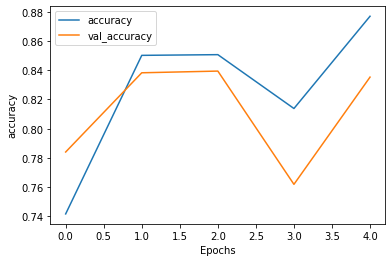

In [16]:
plot_graphs(history, 'accuracy')

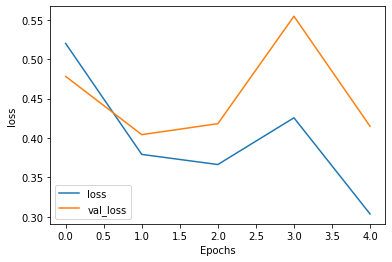

In [17]:
plot_graphs(history, 'loss')